# 1. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define path to project
PROJECT_PATH = '/content/drive/My Drive/TA/Implementasi'
DATASETS_PATH = PROJECT_PATH + '/datasets'
PROCESSED_DATA_PATH = PROJECT_PATH + '/data/processed'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install gensim
!pip install mlflow
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cu124.html
!pip install ijson
!pip install optuna

Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu124.html
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/pyg_lib-0.4.0%2Bpt25cu124-cp311-cp311-linux_x86_64.whl (2.5 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/torch_scatter-2.1.2%2Bpt25cu124-cp311-cp311-linux_x86_64.whl (10.8 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/torch_sparse-0.6.18%2Bpt25cu124-cp311-cp311-linux_x86_64.whl (5.2 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/torch_cluster-1.6.3%2Bpt25cu124-cp311-cp311-linux_x86_64.whl (3.4 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu124/torch_spline_conv-1.2.2%2Bpt25cu124-cp311-cp311-linux_x86_64.whl (1.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.8 MB/s eta 0:00:00


In [ ]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = {
            k: objectview(v) if isinstance(v, dict) else v
            for k, v in d.items()
        }

## Import Libraries

In [ ]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.data as pyg_data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import gdown
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
import re
import math
import torch.optim as optim
import copy
import numpy as np
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
import os

import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_ba

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


## Download CSV Dataset File

In [ ]:
def download_dataset_gdown(file_id, output_file):
    try:
        url = f'https://drive.google.com/uc?id={file_id}'

        gdown.download(url, output_file, quiet=False)

        print(f"File downloaded successfully: {output_file}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")

# download the cleaned dataset
# download_dataset_gdown('1mkVlWWQLGGqEf2cRCgvxMmLx4_PAxbzu', 'sessions.csv')

In [ ]:
# sessions = pd.read_csv('sessions.csv')
# sessions.head()

# Preprocessing

Tahap-tahap Preprocessing dimulai dari:
1. Parsing Data
2. Split data menjadi data latih, validasi, dan tes
3. Transform the sequential data

In [ ]:
label_encoder = joblib.load(DATASETS_PATH + '/product_id_encoder.joblib')

In [ ]:
# download_dataset_gdown('1i-0mMl7B0ey-hHUHujGoCiclesJtrEM7', 'sequences.csv')

In [ ]:
import ijson
import json
import decimal

class DecimalEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, decimal.Decimal):
            return float(obj)
        return super(DecimalEncoder, self).default(obj)


file_path = PROCESSED_DATA_PATH + '/data_joined.json'

def count_items_in_json(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for _ in ijson.items(f, 'item'))

def convert_decimal_to_float(obj):
    if isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_decimal_to_float(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_decimal_to_float(i) for i in obj]
    return obj

def read_sequences(type_):
    if type_ == 'normal':
        return pd.read_csv(DATASETS_PATH + '/sequences.csv')["sequence"]
    elif type_ == 'complete':
        items = []
        with open(file_path, 'r') as f:
            objects = ijson.items(f, 'item')

            for i, obj in enumerate(tqdm(objects, desc="Reading data...")):
                items.append(convert_decimal_to_float(obj))

        return items
    else:
        raise ValueError("Invalid type. Expected 'normal' or 'complete'.")

# sequences = create_full_sequence(sessions)
transformed_seq = read_sequences('complete')


Reading data...: 0it [00:00, ?it/s]

In [ ]:
# print(json.dumps(sequences[:2], cls=DecimalEncoder, indent=4))
# print(len(sequences))

## Split Dataset as train, val, and test

In [ ]:
from sklearn.model_selection import train_test_split



In [ ]:
print(len(transformed_seq))

1182181


In [ ]:
# transformed_seq = parallel_transform(sequences, mapping)
import ast
import gc
def transform_the_seq(seqs):
    return [ast.literal_eval(seq) for seq in seqs]

In [ ]:
print(json.dumps(transformed_seq[10], indent=4))

{
    "session_id": 10,
    "sequence": [
        {
            "id": "B081KHS89M",
            "title": "includes item code online virtual game gift card roblox <unk> robux exclusive",
            "price": 10.0,
            "label": 198008
        },
        {
            "id": "B08W6W1SP1",
            "title": "includes item code online virtual game gift card roblox <unk> robux exclusive",
            "price": 12.99,
            "label": 287669
        },
        {
            "id": "B00D8CXYXC",
            "title": "email animated woofy voucher uk amazon egift co <unk> birthday",
            "price": 12.99,
            "label": 43921
        },
        {
            "id": "B01MYGEMXU",
            "title": "hot summer uk voucher amazon eu egift co <unk> dog email",
            "price": 12.99,
            "label": 91724
        }
    ],
    "length": 4
}


In [ ]:
train_sequences, test_sequences = train_test_split(transformed_seq, test_size=0.1, random_state=42)
test_sequences, val_sequences = train_test_split(test_sequences, test_size=0.5, random_state=42)
print(len(train_sequences), len(val_sequences), len(test_sequences))
train_sequences[0]

1063962 59110 59109


{'session_id': 303482,
 'sequence': [{'id': 'B00GMMDUIY',
   'title': 'table small wood xx ikea lack beige coffee',
   'price': 19.93,
   'label': 48292},
  {'id': 'B0822FLX45',
   'title': 'frame rustic songmics high vasagle assembly lbtx brown rectangular and cm narrow steel pub dining table industrial easy black bar kitchen alloy',
   'price': 12.99,
   'label': 199663},
  {'id': 'B07V22FSNQ',
   'title': 'frame rustic vasagle brown and living cm people steel for heavy style dining table industrial room black duty kdtx kitchen alloy <unk> metal',
   'price': 12.99,
   'label': 175537}],
 'length': 3}

## Convert the dataset into graph dataset file

In [ ]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, sequences, transform=None, pre_transform=None):
        self.sequences = sequences
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        sessions = self.sequences # session
        data_list = []

        # Add tqdm progress bar for session processing
        for session in tqdm(sessions, desc="Processing sessions", unit="session"):
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(pd.Series(session))
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor([senders, receivers], dtype=torch.long)
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

         # Save processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return len(self.sequences)

In [ ]:
from collections import defaultdict
import re

# dictionary untuk menyimpan maksimal vocabulary untuk masing-masing feature
MAX_VOCABS = {
    "title": 100000,
}



In [ ]:
import nltk

# Download nltk resources if you haven't already
try:
    nltk.download('punkt_tab')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize

feature_vocabs = defaultdict(dict)  # {feature: {token: index}}
feature_max_lengths = defaultdict(int)  # {feature: max_observed_sequence_length}
vocabs_built = False  # Flag to track if vocabularies have been built

class GraphDatasetWithFeatures(pyg_data.InMemoryDataset):
    # Static class variables to share across dataset splits

    def __init__(self, root, file_name, sequences, transform=None, pre_transform=None, build_vocab=False):
        self.sequences = sequences # sequence of session
        self.file_name = file_name # file name to access the processed data
        self.should_build_vocab = build_vocab  # Only build vocab on first instance (at train)

        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def build_feature_vocabs(self, sessions):
        """Build vocabulary - now a class method so it updates static class variables"""
        global feature_vocabs, feature_max_lengths, vocabs_built
        if vocabs_built:
            print("Vocabularies already built, skipping...")
            return

        print("Building feature vocabularies...")
        feature_counts = defaultdict(Counter)

        # First pass: compute max sequence lengths and token frequencies
        for session in tqdm(sessions):
            for item in session["sequence"][:-1]:
                for feature in MAX_VOCABS.keys():
                    text = item.get(feature, "")
                    if isinstance(text, (int, float)):
                        text = str(text)
                    if text is None:
                        text = ''
                    cleaned_text = re.sub(r'[^\w\s]', '', text.lower())
                    tokens = word_tokenize(cleaned_text)
                    # Update max sequence length for the feature
                    feature_max_lengths[feature] = max(
                        feature_max_lengths[feature], len(tokens))
                    # Update token frequencies
                    feature_counts[feature].update(tokens)

        # Build vocab for each feature (capped at MAX_VOCABS)
        for feature in MAX_VOCABS.keys():
            max_size = MAX_VOCABS[feature] - 1  # Reserve index 0 for <unk>
            tokens = [token for token, _ in feature_counts[feature].most_common(max_size)]
            feature_vocabs[feature] = {'<unk>': 0}
            feature_vocabs[feature].update({token: i+1 for i, token in enumerate(tokens)})

        vocabs_built = True
        print(f"Vocabularies built - features: {list(feature_vocabs.keys())}")
        print(f"Max lengths: {dict(feature_max_lengths)}")

    def numericalize_feature(self, text, feature):
        global feature_vocabs, feature_max_lengths, vocabs_built
        """Convert text to numerical indices - now a class method using static vocabularies"""
        if isinstance(text, (int, float)):
            text = str(text)

        if text is None:
            text = ''
        cleaned_text = re.sub(r'[^\w\s]', '', str(text).lower())
        tokens = word_tokenize(cleaned_text)
        # Convert tokens to indices
        indices = [feature_vocabs[feature].get(token, 0) for token in tokens]
        # Truncate/pad to observed max length for this feature
        max_len = feature_max_lengths[feature]
        if len(indices) > max_len:
            indices = indices[:max_len]
        else:
            indices += [0] * (max_len - len(indices))
        return indices

    def process(self):
        global feature_vocabs, feature_max_lengths, vocabs_built
        sessions = self.sequences
        data_list = []

        # Only build vocabularies once (typically on training data)
        if self.should_build_vocab and not vocabs_built:
            self.build_feature_vocabs(sessions)
        elif not vocabs_built:
            raise ValueError("Vocabularies have not been built yet. Initialize with build_vocab=True first.")

        for session in tqdm(sessions, desc=f"Processing {self.file_name} sessions"):
            length = session["length"]
            session = session["sequence"]
            session_features = session[:-1]
            y_label = int(session[-1]["label"])

            labels = [item["label"] for item in session_features]
            codes, uniques = pd.factorize(labels)
            x = torch.tensor(uniques, dtype=torch.int32).unsqueeze(1)
            senders, receivers = codes[:-1], codes[1:]

            seen = set()
            uniques_data = []
            for item in session_features:
                if item["label"] not in seen:
                    uniques_data.append(item)
                    seen.add(item["label"])
            uniques_df = pd.DataFrame(uniques_data)

            node_features_title = []
            node_features_price = []

            for _, row in uniques_df.iterrows():
                feature_vector_cat = {}
                for feature in MAX_VOCABS.keys():
                    indices = self.numericalize_feature(row.get(feature, ""), feature)
                    if feature not in feature_vector_cat:
                        feature_vector_cat[feature] = []
                    feature_vector_cat[feature].extend(indices)
                price = row.get("price", 0.0)

                # insert for each feature attribute
                # (1) title
                node_features_title.append(torch.tensor(feature_vector_cat['title'], dtype=torch.long))
                node_features_price.append(torch.tensor([price], dtype=torch.float32))

            x_title = torch.stack(node_features_title) if node_features_title else torch.empty((0, 1), dtype=torch.long)
            x_price = torch.stack(node_features_price) if node_features_price else torch.empty((0, 1), dtype=torch.float32)

            edge_index = torch.tensor([senders, receivers], dtype=torch.long)
            y = torch.tensor([y_label], dtype=torch.long)

            data = pyg_data.Data(x=x, x_title=x_title, x_price=x_price, edge_index=edge_index, length=length, y=y)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def len(self):
        return len(self.sequences)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Pembentukan vocabulary hanya dilakukan pada data train untuk mencegah kebocoran data vocabulary dari val dan test

In [ ]:
ROOT = PROCESSED_DATA_PATH + '/graph'
train_dataset = GraphDatasetWithFeatures(root=ROOT, file_name='train', sequences=train_sequences, build_vocab=True)
val_dataset = GraphDatasetWithFeatures(root=ROOT, file_name='val', sequences=val_sequences, build_vocab=False)
test_dataset = GraphDatasetWithFeatures(root=ROOT, file_name='test', sequences=test_sequences, build_vocab=False)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1063962
59110
59109


In [ ]:
# graph = train_dataset[7002]
import random
print(len(test_dataset))
graph = test_dataset[random.randint(0, len(test_dataset) - 1)]
print(graph)


59109
Data(x=[5, 1], edge_index=[2, 6], y=[1], x_title=[5, 132], x_price=[5, 1], length=[1])


## Graph Visualization

We will only display the graph of the session

In [ ]:
def visualize_graph(data, index=0, filename="graph"):
    # Get the PyG Data object from your dataset
    graph = data[index]

    print(len(data))

    # Convert PyG Data to NetworkX graph (directed by default)
    G = to_networkx(graph, node_attrs=['x'], to_undirected=False)

    # Create a plot
    plt.figure(figsize=(10, 8))

    # Draw the graph
    pos = nx.spring_layout(G)
    node_labels = {i: graph.x[i].item() for i in G.nodes()}

    nx.draw(G, pos, with_labels=True,
            labels=node_labels,
            node_color='lightblue',
            edge_color='gray',
            arrows=True,
            arrowstyle='-|>',
            node_size=800,
            font_size=12)

    plt.title(f"Graph Visualization (Class: {graph.y.item()})")
    # plt.show()
    # save the figure
    save_dir = PROJECT_PATH + "/SRGNN/figures"

    # Save
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{filename}.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Saved graph visualization to: {save_path}")


In [ ]:
import random
# random.seed(1905)
train_index = random.randint(0, len(train_dataset) - 1)
test_index = random.randint(0, len(test_dataset) -1)
val_index = random.randint(0, len(val_dataset) - 1)
visualize_graph(train_dataset, train_index, filename="train")
visualize_graph(test_dataset, test_index, filename="test")
visualize_graph(val_dataset, val_index, filename="val")

In [ ]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.out_channels = out_channels
        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return torch.matmul(adj_t, x, reduce=self.aggr)


In [ ]:
class FeatureEmbedding(nn.Module):
    def __init__(self,
                 num_embeddings,
                 title_embedding_dim,
                 price_out_dim,
                 hidden_size,
                 ):
        super(FeatureEmbedding, self).__init__()
        self.title_embedding = nn.Embedding(num_embeddings["title"], title_embedding_dim)
        self.price_layer = nn.Linear(1, price_out_dim)
        self.hidden_size = hidden_size
        self.linear = nn.Linear(title_embedding_dim + price_out_dim, hidden_size)

    def forward(self, title, price):
        # Ensure correct tensor types
        title_emb = self.title_embedding(title.long())
        title_emb = title_emb.mean(dim=1) # pool title embedding
        price_emb = self.price_layer(price.float())
        # print(title_emb.shape)
        # print(brand_emb.shape)
        # print(color_emb.shape)
        # print(price_emb.shape)

        all_emb =  torch.cat([title_emb, price_emb], dim=1)
        # print(all_emb.shape)
        return self.linear(all_emb)

class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items, **kwargs):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items
        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        self.gated = GatedSessionGraphConv(self.hidden_size)
        self.feature_embedding_dropout = nn.Dropout(0.2)
        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)
        self.concat_embedding = nn.Linear(2*self.hidden_size, self.hidden_size)

        ## define the feature embedding layer
        ## make sure that all arguments satisfied before initialize it
        required_param = [
            "num_embeddings",
            "title_embedding_dim",
            "price_out_dim",
        ]

        if all(key in kwargs for key in required_param):
            self.feature_embedding = FeatureEmbedding(
                num_embeddings= kwargs.get("num_embeddings"),
                title_embedding_dim=kwargs.get("title_embedding_dim"),
                price_out_dim=kwargs.get("price_out_dim"),
                hidden_size=self.hidden_size,
            )
            self.use_feature = True
        else:
            self.feature_embedding = None
            self.use_feature = False

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0)
        item_embedding = self.embedding(x).squeeze()

        # Apply feature embedding if enabled
        if self.use_feature:
            title, price = data.x_title, data.x_price
            feature_emb = self.feature_embedding(title, price)
            feature_emb = self.feature_embedding_dropout(feature_emb).squeeze()

            # Combine item embedding with feature embedding
            embedding = torch.cat([item_embedding, feature_emb], dim=-1)
            embedding = self.concat_embedding(embedding)
        else:
            embedding = item_embedding

        v_i = self.gated(embedding, edge_index)

        # Divide nodes by session
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        s_l = v_n
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        z = torch.mm(self.embedding.weight, s_h.T).T

        return z

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, best_acc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'best_acc': best_acc
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [ ]:
def test(loader, test_model, is_validation=False, save_model_preds=False, k=20, save_results=False, result_file='test_results.json'):
    test_model.eval()
    correct = 0
    total_samples = 0

    # Only track these if not validation
    top_k_correct = 0
    mrr_sum = 0.0

    # short session (lengths < 4)
    correct_short = 0
    top_k_correct_short = 0
    mrr_sum_short = 0.0
    total_samples_short = 0

    # medium session (length < 10)
    correct_medium = 0
    top_k_correct_medium = 0
    mrr_sum_medium = 0.0
    total_samples_medium = 0

    # long session ( length >= 10)
    correct_long = 0
    top_k_correct_long = 0
    mrr_sum_long = 0.0
    total_samples_long = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in tqdm(loader):
            data.to(device)
            score = test_model(data)
            length = data.length

            # Basic accuracy
            pred = score.argmax(dim=1)
            label = data.y

            correct += (pred == label).sum().item() # All
            # short
            correct_short += (pred[length < 4] == label[length < 4]).sum().item()
            correct_medium += (pred[(length >= 4) & (length < 10)] == label[(length >= 4) & (length < 10)]).sum().item()
            correct_long += (pred[length >= 10] == label[length >= 10]).sum().item()

            batch_size = label.size(0)
            total_samples += batch_size
            total_samples_short += (length < 4).sum().item()
            total_samples_medium += ((length >= 4) & (length < 10)).sum().item()
            total_samples_long += (length >= 10).sum().item()

            # Fast top-k calculation (only if not validation)
            if not is_validation:
                # Simple top-k implementation
                topk_values, topk_indices = torch.topk(score, k=k, dim=1)

                # Compare with ground truth
                for i in range(batch_size):
                    if label[i] in topk_indices[i]:
                        top_k_correct += 1
                        # Find position (1-indexed)
                        pos = (topk_indices[i] == label[i]).nonzero(as_tuple=True)[0].item() + 1
                        mrr_sum += 1.0 / pos

                        # Short session top-k
                        if length[i] < 4:
                            top_k_correct_short += 1
                            pos_short = (topk_indices[i] == label[i]).nonzero(as_tuple=True)[0].item() + 1
                            mrr_sum_short += 1.0 / pos_short

                        # Medium session top-k
                        if (length[i] >= 4) & (length[i] < 10):
                            top_k_correct_medium += 1
                            pos_medium = (topk_indices[i] == label[i]).nonzero(as_tuple=True)[0].item() + 1
                            mrr_sum_medium += 1.0 / pos_medium

                        # Long session top-k
                        if length[i] >= 10:
                            top_k_correct_long += 1
                            pos_long = (topk_indices[i] == label[i]).nonzero(as_tuple=True)[0].item() + 1
                            mrr_sum_long += 1.0 / pos_long

            if save_model_preds:
                all_preds.extend(pred.cpu().tolist())
                all_labels.extend(label.cpu().tolist())

    # Save predictions if needed
    if save_model_preds and all_preds:
        df = pd.DataFrame({'pred': all_preds, 'label': all_labels})
        df.to_csv('pred.csv', index=False)

    # Calculate final metrics for overall accuracy
    accuracy = correct / total_samples

    # Calculate final metrics for short, medium, and long sessions
    accuracy_short = correct_short / total_samples_short if total_samples_short > 0 else 0
    accuracy_medium = correct_medium / total_samples_medium if total_samples_medium > 0 else 0
    accuracy_long = correct_long / total_samples_long if total_samples_long > 0 else 0

    hit_rate = top_k_correct / total_samples if total_samples > 0 else 0
    mrr = mrr_sum / total_samples if total_samples > 0 else 0

    hit_rate_short = top_k_correct_short / total_samples_short if total_samples_short > 0 else 0
    mrr_short = mrr_sum_short / total_samples_short if total_samples_short > 0 else 0

    hit_rate_medium = top_k_correct_medium / total_samples_medium if total_samples_medium > 0 else 0
    mrr_medium = mrr_sum_medium / total_samples_medium if total_samples_medium > 0 else 0

    hit_rate_long = top_k_correct_long / total_samples_long if total_samples_long > 0 else 0
    mrr_long = mrr_sum_long / total_samples_long if total_samples_long > 0 else 0

    # Display results
    if not is_validation:
        pass
        # print(f"Overall Accuracy: {accuracy:.4f}")
        # print(f"Hit@{k}: {hit_rate:.4f}, MRR@{k}: {mrr:.4f}")

        # print(f"Short Session (length < 4):")
        # print(f"  Accuracy: {accuracy_short:.4f}, Hit@{k}: {hit_rate_short:.4f}, MRR@{k}: {mrr_short:.4f}")

        # print(f"Medium Session (length >= 4 and < 10):")
        # print(f"  Accuracy: {accuracy_medium:.4f}, Hit@{k}: {hit_rate_medium:.4f}, MRR@{k}: {mrr_medium:.4f}")

        # print(f"Long Session (length >= 10):")
        # print(f"  Accuracy: {accuracy_long:.4f}, Hit@{k}: {hit_rate_long:.4f}, MRR@{k}: {mrr_long:.4f}")

    # Save results to CSV or JSON
    if save_results:
        # Save to CSV
        results_df = pd.DataFrame({
            'Session Length': ['All', 'Short (<4)', 'Medium (4-10)', 'Long (>=10)'],
            'Accuracy': [accuracy, accuracy_short, accuracy_medium, accuracy_long],
            f'Hit@{k}': [hit_rate, hit_rate_short, hit_rate_medium, hit_rate_long],
            f'MRR@{k}': [mrr, mrr_short, mrr_medium, mrr_long]
        })
        results_df.to_csv('test_results.csv', index=False)

        # Save to JSON
        results_dict = {
            'overall': {
                'accuracy': accuracy,
                'hit_rate': hit_rate,
                'mrr': mrr
            },
            'short': {
                'accuracy': accuracy_short,
                'hit_rate': hit_rate_short,
                'mrr': mrr_short
            },
            'medium': {
                'accuracy': accuracy_medium,
                'hit_rate': hit_rate_medium,
                'mrr': mrr_medium
            },
            'long': {
                'accuracy': accuracy_long,
                'hit_rate': hit_rate_long,
                'mrr': mrr_long
            }
        }
        with open(result_file, 'w') as f:
            json.dump(results_dict, f, indent=4)


    if is_validation:
        return accuracy, 0, 0
    else:
        results_dict = {
          'overall': {
              'accuracy': accuracy,
              'hit_rate': hit_rate,
              'mrr': mrr
          },
          'short': {
              'accuracy': accuracy_short,
              'hit_rate': hit_rate_short,
              'mrr': mrr_short
          },
          'medium': {
              'accuracy': accuracy_medium,
              'hit_rate': hit_rate_medium,
              'mrr': mrr_medium
          },
          'long': {
              'accuracy': accuracy_long,
              'hit_rate': hit_rate_long,
              'mrr': mrr_long
          }
        }

        results = objectview(results_dict)
        return results

In [ ]:
# import torch.distributed as dist
# import torch.multiprocessing as mp
# from torch.nn.parallel import DistributedDataParallel as DDP
# from torch.utils.data.distributed import DistributedSampler
import os

In [ ]:
print(torch.cuda.device_count())

# Training

## Fungsi untuk Training and save checkpoint

In [ ]:
import torch
import mlflow
import mlflow.pytorch
import copy
from tqdm.auto import tqdm
import os

# Define checkpoint directory in Google Drive
CHECKPOINT_DIR = PROJECT_PATH + "/SRGNN/Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)  # Create the directory if it doesn't exist
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
BEST_MODEL_PATH = f"{CHECKPOINT_DIR}/srgnn_{len(transformed_seq)}_best_model.pt"
def train_and_save(model, args, train_data, val_data, save_every=5, start_from_beginning=True):
    train_loader = pyg_data.DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)
    val_loader = pyg_data.DataLoader(val_data, batch_size=args.batch_size, shuffle=False, drop_last=True)

    # Initialize MLflow
    mlflow.set_tracking_uri(PROJECT_PATH + "/SRGNN/mlruns")
    mlflow.set_experiment("SRGNN_Training")

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2_penalty)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step, gamma=args.gamma)
    criterion = torch.nn.CrossEntropyLoss()

    # Load checkpoint if resuming
    checkpoint_path = f"{CHECKPOINT_DIR}/srgnn_{len(transformed_seq)}_checkpoint.pt"
    if os.path.exists(checkpoint_path) and not start_from_beginning:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        start_epoch = checkpoint["epoch"]
        print(f"Resuming training from epoch {start_epoch}")

         # Load best model if available
        if os.path.exists(BEST_MODEL_PATH):
            best_checkpoint = torch.load(BEST_MODEL_PATH)
            best_model = copy.deepcopy(model)
            best_model.load_state_dict(best_checkpoint["model_state_dict"])
            best_acc = best_checkpoint.get("val_accuracy", 0)
            print(f"Loaded previous best model with accuracy {best_acc:.2f}%")

        # If already completed all epochs, return best model immediately
        if start_epoch >= args.epochs:
            print("Training already completed. Returning last best model.")
            return [], [], [], best_model, best_acc, val_loader
    else:
        start_epoch = 0
        print("Starting training from scratch")

    # Training variables
    losses = []
    val_accs = []
    hit_at_ks = []
    best_acc = 0
    best_model = None

    patience = 0
    epoch = start_epoch
    if start_epoch <= args.epochs:
        for epoch in range(start_epoch, args.epochs):
            total_loss = 0
            model.train()

            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.epochs}")
            for batch in progress_bar:
                batch.to(device)
                optimizer.zero_grad()
                pred = model(batch)
                label = batch.y
                loss = criterion(pred, label)

                # print("Prediction Shape: ", pred.shape)
                # print("Label Shape: ", label.shape)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * batch.num_graphs
                progress_bar.set_postfix(loss=loss.item())

            total_loss /= len(train_loader.dataset)
            losses.append(total_loss)

            scheduler.step()

            # Validate every epoch
            val_acc, mrr_at_k, hit_at_k = test(val_loader, model, is_validation=True)
            val_acc = val_acc * 100
            hit_at_k = hit_at_k * 100
            mrr_at_k = mrr_at_k * 100
            print(f"Validation Accuracy: {val_acc}")
            val_accs.append(val_acc)
            hit_at_ks.append(hit_at_k)


            # Log to MLflow
            with mlflow.start_run(nested=True):
                mlflow.log_metric("loss", total_loss, step=epoch)
                mlflow.log_metric("val_accuracy", val_acc, step=epoch)
                # mlflow.log_metric("hit_at_ks_accuracy", hit_at_k, step=epoch)

            # Save checkpoint to Google Drive every `save_every` epochs
            if (epoch + 1) % save_every == 0:
                checkpoint_path = f"{CHECKPOINT_DIR}/srgnn_{len(sequences)}_checkpoint.pt"
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                }, checkpoint_path)
                mlflow.pytorch.log_model(model, f"SRGNN_Epoch_{epoch+1}")
                print(f"Checkpoint saved at {checkpoint_path}")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model = copy.deepcopy(model)
                patience = 0

                # Save best model checkpoint
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": best_model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    "val_accuracy": best_acc
                }, BEST_MODEL_PATH)
                mlflow.pytorch.log_model(best_model, f"Best_Model_Epoch_{epoch+1}")
                print(f"New best model saved at epoch {epoch+1} with acc {best_acc:.2f}% -> {BEST_MODEL_PATH}")
            else:
                patience += 1
                if patience >= getattr(args, 'patience', 5):
                    print("Early stopping due to no improvement in validation accuracy.")
                    break
    else:
        epoch = start_epoch
    # save at the end of training
    checkpoint_path = f"{CHECKPOINT_DIR}/srgnn_{len(sequences)}_checkpoint.pt"
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
    }, checkpoint_path)

    mlflow.pytorch.log_model(model, f"SRGNN_Epoch_{epoch+1}")
    print(f"Checkpoint saved at {checkpoint_path}")

    # save the training history plot


    return val_accs, hit_at_ks, losses, best_model, best_acc, val_loader

In [ ]:
print(len(transformed_seq))

1182181


## Definisi argumen

In [ ]:
# Define the hyperparameters.
class ObjectViewNonRecursive(object):
    def __init__(self, d):
        self.__dict__ = d

num_embeddings = {
    "item": label_encoder.classes_.shape[0],
    "title": MAX_VOCABS["title"],
}

args = {
    'batch_size': 400,
    'hidden_dim': 32,
    'epochs': 20,
    'l2_penalty': 0.00001,
    'gamma': 0.1,
    'step': 30,
    'lr': 0.001,
    'num_items': label_encoder.classes_.shape[0],
    'num_embeddings': num_embeddings,
    'title_embedding_dim': 16,
    'price_out_dim': 8,
}

print(label_encoder.classes_.shape[0])

args = ObjectViewNonRecursive(args)

500180


In [ ]:
print(torch.cpu.device_count())

1


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

inisiasi *number of embeddings*

inisiasi model SRGNN

In [ ]:
model = SRGNN(args.hidden_dim,
              args.num_items,
              num_embeddings=args.num_embeddings,
              title_embedding_dim=args.title_embedding_dim,
              price_out_dim=args.price_out_dim).to(device)

## Melakukan *training*

In [ ]:
# os.environ.update('CUDA_LAUNCH_BLOCKING', 1)

# val_accs, top_k_accs, losses, best_model, best_acc, test_loader = train_and_save(model, args, train_dataset, val_dataset, save_every=2, start_from_beginning=False)
val_accs, top_k_accs, losses, best_model, best_acc, test_loader = train_and_save(model, args, train_dataset, val_dataset, save_every=2, start_from_beginning=True)



Starting training from scratch


100%|██████████| 147/147 [00:13<00:00, 11.16it/s]


Validation Accuracy: 0.005102040816326531


100%|██████████| 147/147 [00:06<00:00, 21.77it/s]


Validation Accuracy: 0.030612244897959183


2025/05/06 11:26:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 11:26:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 11:26:21 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.67it/s]


Validation Accuracy: 0.14965986394557823


100%|██████████| 147/147 [00:06<00:00, 21.75it/s]


Validation Accuracy: 1.0459183673469388


2025/05/06 11:45:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 11:46:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 11:46:05 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.66it/s]


Validation Accuracy: 3.054421768707483


100%|██████████| 147/147 [00:06<00:00, 21.60it/s]


Validation Accuracy: 5.127551020408163


2025/05/06 12:05:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 12:05:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 12:05:55 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.91it/s]


Validation Accuracy: 6.741496598639456


100%|██████████| 147/147 [00:06<00:00, 21.88it/s]


Validation Accuracy: 7.88265306122449


2025/05/06 12:25:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 12:25:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 12:25:43 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.54it/s]


Validation Accuracy: 8.624149659863946


100%|██████████| 147/147 [00:06<00:00, 21.96it/s]


Validation Accuracy: 9.29251700680272


2025/05/06 12:45:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 12:45:35 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 12:45:35 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.63it/s]


Validation Accuracy: 9.61734693877551


100%|██████████| 147/147 [00:06<00:00, 21.77it/s]


Validation Accuracy: 9.763605442176871


2025/05/06 13:05:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 13:05:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 13:05:21 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.65it/s]


Validation Accuracy: 9.831632653061224


100%|██████████| 147/147 [00:06<00:00, 21.59it/s]


Validation Accuracy: 9.933673469387754


2025/05/06 13:25:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 13:25:18 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 13:25:18 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.63it/s]


Validation Accuracy: 10.013605442176871


100%|██████████| 147/147 [00:06<00:00, 21.77it/s]


Validation Accuracy: 9.91156462585034


2025/05/06 13:45:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 13:45:22 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 13:45:22 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.74it/s]


Validation Accuracy: 9.710884353741497


100%|██████████| 147/147 [00:06<00:00, 21.56it/s]


Validation Accuracy: 10.034013605442176


2025/05/06 14:05:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 14:05:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 14:05:17 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


100%|██████████| 147/147 [00:06<00:00, 21.62it/s]


Validation Accuracy: 9.845238095238095


100%|██████████| 147/147 [00:06<00:00, 21.68it/s]


Validation Accuracy: 9.853741496598639


2025/05/06 14:25:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 14:25:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 14:25:12 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


2025/05/06 14:25:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/06 14:25:22 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/06 14:25:22 WARNING mlflow.utils.requirements_utils: Found torch-sparse version (0.6.18+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'torch-sparse==0.6.18' without the local version label to make it installable from PyPI. To specify pip requirements containing local versio

Checkpoint saved at /content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_1182181_checkpoint.pt


## Continue training

In [ ]:
# test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train_and_save(model, args, train_dataset, val_dataset, start_epoch=last_epoch, save_every=10)

## Evaluation Result

[0.005102040816326531, 0.030612244897959183, 0.14965986394557823, 1.0459183673469388, 3.054421768707483, 5.127551020408163, 6.741496598639456, 7.88265306122449, 8.624149659863946, 9.29251700680272, 9.61734693877551, 9.763605442176871, 9.831632653061224, 9.933673469387754, 10.013605442176871, 9.91156462585034, 9.710884353741497, 10.034013605442176, 9.845238095238095, 9.853741496598639] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum test set accuracy: 10.034013605442176
Minimum loss: 3.621543172072308


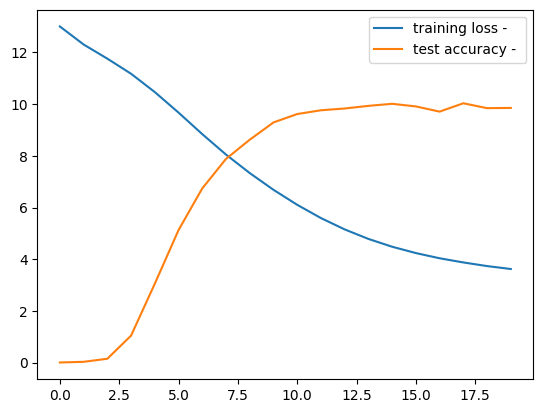

In [ ]:
print(val_accs, top_k_accs)
print("Maximum test set accuracy: {0}".format(max(val_accs)))
print("Minimum loss: {0}".format(min(losses)))

# plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - ")
plt.plot(val_accs, label="validation accuracy" + " - ")
plt.legend()
plt.show()

# save figure
plt.savefig(PROJECT_PATH + "SRGNN/figures/training_history")

In [ ]:
k = 20
test_loader = pyg_data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
accuracy, hit_at_k, mrr_at_k = test(test_loader, best_model, is_validation=False, k=20)

 16%|█▌        | 23/148 [00:05<00:31,  3.97it/s]

In [ ]:
print(f"Test Accuracy: {accuracy:.4f}%")
print(f"Hit@{k}: {hit_at_k:.4f}%")
print(f"MRR@{k}: {mrr_at_k:.4f}%")

## Save best model state

In [ ]:
torch.save(best_model.state_dict(), '/content/drive/My Drive/Tugas Akhir/SRGNN/best_model.pt')

load model

In [ ]:

model.load_state_dict(torch.load('/content/drive/My Drive/Tugas Akhir/SRGNN/best_model.pt'))

<All keys matched successfully>

In [ ]:
k = 20
test_loader = pyg_data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
results = test(test_loader, model, is_validation=False, k=20)

100%|██████████| 148/148 [00:38<00:00,  3.84it/s]

Overall Accuracy: 0.1004
Hit@20: 0.2314, MRR@20: 0.1327
Short Session (length < 4):
  Accuracy: 0.1119, Hit@20: 0.2478, MRR@20: 0.1462
Medium Session (length >= 4 and < 10):
  Accuracy: 0.0975, Hit@20: 0.2275, MRR@20: 0.1292
Long Session (length >= 10):
  Accuracy: 0.0649, Hit@20: 0.1781, MRR@20: 0.0905


In [ ]:
print(f"Test Accuracy: {results.overall.accuracy*100:.4f}%")
print(f"Hit@{k}: {results.overall.hit_rate*100:.4f}%")
print(f"MRR@{k}: {results.overall.mrr*100:.4f}%")

Test Accuracy: 10.0442%
Hit@20: 23.1386%
MRR@20: 13.2658%


## Disconnect when it already finished while I am sleeping

### Hyperparameter Tuning

### Definisi fungsi optuna

In [ ]:
import optuna
from optuna.trial import TrialState
import time
from optuna.visualization import plot_param_importances, plot_optimization_history
from optuna.importance import get_param_importances
import seaborn as sns
from tqdm.auto import tqdm as tqdm_auto
from functools import partial
import matplotlib.ticker as ticker

# Define checkpoint directory in Google Drive
CHECKPOINT_DIR = PROJECT_PATH + "/SRGNN/Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def objective(trial, model_class, args, train_data, val_data, device):
    """
    Optuna objective function for hyperparameter optimization
    """
    # Define hyperparameters to search
    lr = trial.suggest_float("lr", 1e-3, 1e-2, log=True)
    hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64])
    batch_size = trial.suggest_categorical("batch_size", [256, 384, 512])
    l2_penalty = trial.suggest_float("l2_penalty", 1e-6, 1e-3, log=True)

    # If using feature embeddings, optimize those hyperparameters too
    use_features = trial.suggest_categorical("use_features", [True, False])

    if use_features:
        title_embedding_dim = trial.suggest_categorical("title_embedding_dim", [16, 32])
        price_out_dim = trial.suggest_categorical("price_out_dim", [8, 16])
    else:
        title_embedding_dim = None
        price_out_dim = None

    # Update args with trial hyperparameters
    args.lr = lr
    args.hidden_size = hidden_size
    args.batch_size = batch_size
    args.l2_penalty = l2_penalty

    # Create train and validation dataloaders with the trial batch size
    train_loader = pyg_data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = pyg_data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

    # Initialize model with trial hyperparameters
    if use_features and title_embedding_dim and price_out_dim:
        model = model_class(
            hidden_size=hidden_size,
            n_items=args.n_items,
            num_embeddings=args.num_embeddings,
            title_embedding_dim=title_embedding_dim,
            price_out_dim=price_out_dim
        ).to(device)
    else:
        model = model_class(
            hidden_size=hidden_size,
            n_items=args.n_items
        ).to(device)

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=args.l2_penalty)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step, gamma=args.gamma)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop with early stopping
    best_val_acc = 0.0
    try:
        patience = args.patience
    except:
        patience = 5
    patience_counter = 0

    epoch_range = tqdm_auto(range(args.epochs), desc=f"Trial {trial.number}", leave=False)
    for epoch in epoch_range:
        model.train()
        total_loss = 0

        batch_iter = tqdm_auto(train_loader, desc=f"Train Epoch {epoch+1}", leave=False)
        for batch in batch_iter:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

            batch_iter.set_postfix({"loss": f"{loss.item():.4f}"})

        scheduler.step()

        # Validation
        try:
            val_acc, _, _ = test(val_loader, model, is_validation=True)
            val_acc *= 100
        except Exception as e:
            print(f"Validation failed: {e}")
            val_acc = 0.0

        # Update epoch progress
        postfix_dict = {
            "loss": f"{total_loss/len(train_loader.dataset):.4f}",
            "val_acc": f"{val_acc:.4f}%",
            "best_val_acc": f"{best_val_acc:.4f}%"
        }
        epoch_range.set_postfix(postfix_dict)

        # Report intermediate value to Optuna for pruning
        trial.report(val_acc, epoch)

        # Handle pruning based on intermediate results
        if trial.should_prune():
            postfix_dict["status"] = "pruned"
            epoch_range.set_postfix(postfix_dict)
            raise optuna.exceptions.TrialPruned()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                postfix_dict["status"] = "early_stopped"
                epoch_range.set_postfix(postfix_dict)
                print(f"Early stopping at epoch {epoch}")
                break

    # Log to MLflow
    try:
        with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
            mlflow.log_params({
                "lr": lr,
                "hidden_size": hidden_size,
                "batch_size": batch_size,
                "l2_penalty": l2_penalty,
                "use_features": use_features,
                "title_embedding_dim": title_embedding_dim if use_features else "N/A",
                "price_out_dim": price_out_dim if use_features else "N/A"
            })
            mlflow.log_metric("best_val_accuracy", best_val_acc)
    except Exception as e:
        print(f"{e}")

    return max(best_val_acc, 0.0)



def run_optuna_optimization(model_class, args, train_data, val_data, device, n_trials=50, timeout=None, start_from_beginning=True):
    """
    Run Optuna hyperparameter optimization

    Args:
        model_class: The model class to optimize
        args: Arguments object containing model configuration
        train_data: Training dataset
        val_data: Validation dataset
        device: Device to run training on
        n_trials: Number of optimization trials
        timeout: Optional timeout in seconds

    Returns:
        best_trial: The best trial
        study: The completed Optuna study
    """
    # Set up MLflow
    mlflow.set_tracking_uri(PROJECT_PATH + "/SRGNN/mlruns")
    mlflow.set_experiment("SRGNN_Hyperparameter_Tuning")

    # Create Optuna study
    study_name = f"srgnn_optimization"
    storage_name = f"sqlite:///{CHECKPOINT_DIR}/optuna_studies.db"

    # Set up pruner and sampler
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    sampler = optuna.samplers.TPESampler(seed=42)

    # Delete existing study if starting fresh
    if start_from_beginning:
        try:
            optuna.delete_study(
                study_name=study_name,
                storage=storage_name
            )
            print(f"Deleted existing study '{study_name}'")
        except KeyError:
            print(f"No existing study '{study_name}' to delete")

    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="maximize",
        pruner=pruner,
        sampler=sampler,
        load_if_exists=not start_from_beginning
    )

    # Calculate remaining trials needed
    current_trials = len(study.trials)
    remaining_trials = max(n_trials - current_trials, 0)

    if remaining_trials == 0:
        print(f"Study already contains {current_trials} trials. No new trials to run.")
        return study.best_trial, study

    # Wrap objective with fixed parameters using partial
    wrapped_objective = partial(
        objective,
        model_class=model_class,
        args=args,
        train_data=train_data,
        val_data=val_data,
        device=device
    )

    # Run optimization
    study.optimize(
        wrapped_objective,
        n_trials=remaining_trials,
        timeout=timeout,
        gc_after_trial=True,
        show_progress_bar=True
    )

    # Get best trial and log to MLflow
    best_trial = study.best_trial

    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # Save study results
    study_results = {
        "best_params": best_trial.params,
        "best_value": best_trial.value,
        "n_trials": len(study.trials),
        "completed_trials": len([t for t in study.trials if t.state == TrialState.COMPLETE]),
        "pruned_trials": len([t for t in study.trials if t.state == TrialState.PRUNED])
    }

    with open(f"{CHECKPOINT_DIR}/optuna_results_{study_name}.json", "w") as f:
        json.dump(study_results, f, indent=4)

    with mlflow.start_run(run_name=f"optuna_summary_{study_name}"):
        mlflow.log_params(best_trial.params)
        mlflow.log_metric("best_val_accuracy", best_trial.value)
        mlflow.log_artifact(f"{CHECKPOINT_DIR}/optuna_results_{study_name}.json")

        # Log importance of hyperparameters
        try:
            param_importances = optuna.importance.get_param_importances(study)
            for param_name, importance in param_importances.items():
                mlflow.log_metric(f"importance_{param_name}", importance)
        except:
            print("Could not compute parameter importances.")

    return best_trial, study

def train_model_with_best_params(model_class, best_params, args, train_data, val_data, test_data, device, start_from_beginning=False):
    """
    Train model with the best hyperparameters found by Optuna

    Args:
        model_class: The model class to train
        best_params: Best hyperparameters from Optuna
        args: Arguments object containing model configuration
        train_data: Training dataset
        val_data: Validation dataset
        test_data: Test dataset
        device: Device to run training on

    Returns:
        best_model: The best model trained with the optimal hyperparameters
        test_results: Test results for the best model
    """
    # Update args with best hyperparameters
    for param_name, param_value in best_params.items():
        if hasattr(args, param_name):
            setattr(args, param_name, param_value)

    # Create dataloaders with optimal batch size
    train_loader = pyg_data.DataLoader(train_data, batch_size=best_params["batch_size"], shuffle=True, drop_last=True)
    val_loader = pyg_data.DataLoader(val_data, batch_size=best_params["batch_size"], shuffle=False, drop_last=True)
    test_loader = pyg_data.DataLoader(test_data, batch_size=best_params["batch_size"], shuffle=False, drop_last=True)

    # Initialize model with best hyperparameters
    if best_params.get("use_features", False):
        model = model_class(
            hidden_size=best_params["hidden_size"],
            n_items=args.n_items,
            num_embeddings=args.num_embeddings,
            title_embedding_dim=best_params["title_embedding_dim"],
            price_out_dim=best_params["price_out_dim"]
        ).to(device)
    else:
        model = model_class(
            hidden_size=best_params["hidden_size"],
            n_items=args.n_items
        ).to(device)

    # Use our existing training function with best hyperparameters
    val_accs, hit_at_ks, losses, best_model, best_acc, _ = train_and_save(
        model=model,
        args=args,
        train_data=train_data,
        val_data=val_data,
        save_every=5,
        start_from_beginning=start_from_beginning
    )

    # skip the plotting if the losses and val_accs are empty and do not reflect the current number of epochs
    if (len(losses) == args.epochs and len(val_accs) == args.epochs):
        plt.plot(losses, label="training loss" + " - ")
        plt.plot(val_accs, label="validation accuracy" + " - ")
        plt.legend()

        # save figure
        plt.savefig(PROJECT_PATH + "/SRGNN/figures/best_model_training_history.png")

    # Test the best model
    test_results = test(test_loader, best_model, save_results=True, result_file=f"{CHECKPOINT_DIR}/best_model_test_results.json")

    # Log final results to MLflow
    with mlflow.start_run(run_name="best_model_final", nested=True):
        mlflow.log_params(best_params)
        mlflow.log_metric("best_val_accuracy", best_acc)

        # Log test metrics
        mlflow.log_metric("test_accuracy", test_results.overall.accuracy)
        mlflow.log_metric("test_hit_rate", test_results.overall.hit_rate)
        mlflow.log_metric("test_mrr", test_results.overall.mrr)

        # Log by session length
        for session_type in ["short", "medium", "long"]:
            for metric_type in ["accuracy", "hit_rate", "mrr"]:
                mlflow.log_metric(f"test_{session_type}_{metric_type}",
                                  getattr(getattr(test_results, session_type), metric_type))

        # Save the best model
        mlflow.pytorch.log_model(best_model, "best_model")

    return best_model, test_results

def visualize_optuna_results(study, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # --- 1. Optimization History ---
    try:
        values = [t.value for t in study.trials if t.value is not None]
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(values) + 1), values, marker="o")
        plt.xlabel("Trial")
        plt.ylabel("Objective Value")
        plt.title("Optimization History")
        plt.grid(True)
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.tight_layout()
        plt.savefig(f"{checkpoint_dir}/optuna_optimization_history.png")
        plt.show()
        plt.close()
        print("[✓] Saved: Optimization History")
    except Exception as e:
        print("[X] Failed to plot Optimization History:", e)

    # --- 2. Parameter Importances ---
    try:
        importances = get_param_importances(study)

        filtered_importances = {
            param: importance
            for param, importance in importances.items()
            if param != "dropout"
        }

        if not filtered_importances:
            print("[!] No parameters left to plot after filtering 'dropout'. Skipping Parameter Importances plot.")
            return

        params = list(filtered_importances.keys())
        scores = list(filtered_importances.values())

        plt.figure(figsize=(10, 6))
        plt.barh(params, scores)
        plt.xlabel("Importance")
        plt.title("Hyperparameter Importances")
        plt.tight_layout()
        plt.savefig(f"{checkpoint_dir}/optuna_param_importances.png")
        plt.show()
        plt.close()
        print("[✓] Saved: Parameter Importances")
    except Exception as e:
        print("[X] Failed to plot Parameter Importances:", e)

    # --- 3. Hyperparameter Relationships ---
    try:
        trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

        data = []
        for t in trials:
            row = t.params.copy()
            row["objective"] = t.value
            data.append(row)

        df = pd.DataFrame(data)

        if "dropout" in df.columns:
            df = df.drop(columns=["dropout"])

        if df.shape[1] > 1:
            sns.pairplot(df, hue="objective", palette="viridis", diag_kind="kde")
            plt.suptitle("Hyperparameter Relationships", y=1.02)
            plt.tight_layout()
            plt.savefig(f"{checkpoint_dir}/optuna_param_relationships.png")
            plt.show()
            plt.close()
            print("[✓] Saved: Hyperparameter Relationships")
        else:
            print("[!] Skipped: Not enough parameters for relationships plot")
    except Exception as e:
        print("[X] Failed to plot Hyperparameter Relationships:", e)

### Menjalankan study

In [ ]:


hp_tuning_args = ObjectViewNonRecursive(
    {
    'batch_size': 512,
    'hidden_size': 32,
    'epochs': 10,
    'l2_penalty': 0.00001,
    'gamma': 0.1,
    'step': 30,
    'lr': 0.001,
    'n_items': label_encoder.classes_.shape[0],
    'num_embeddings': num_embeddings,
    'title_embedding_dim': 16,
    'price_out_dim': 8,
    'n_trials':20,
    'patience':3
}
)



In [ ]:
best_trial, study = run_optuna_optimization(
    model_class=SRGNN,
    args=hp_tuning_args,
    train_data=train_dataset,
    val_data=val_dataset,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    n_trials=hp_tuning_args.n_trials
    ,start_from_beginning=False
)


[I 2025-05-30 12:15:13,148] Using an existing study with name 'srgnn_optimization' instead of creating a new one.


Study already contains 20 trials. No new trials to run.


### Run to continue

In [ ]:
CONTINUE = False

if CONTINUE:
    best_trial, study = run_optuna_optimization(
        model_class=SRGNN,
        args=hp_tuning_args,
        train_data=train_dataset,
        val_data=val_dataset,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        n_trials=hp_tuning_args.n_trials
        ,start_from_beginning=False
    )


In [ ]:
print("Best hyperparameters found:")
for key, value in best_trial.params.items():
    if key != "dropout":
        print(f"  {key}: {value}")

Best hyperparameters found:
  lr: 0.00481534763143035
  hidden_size: 64
  batch_size: 512
  l2_penalty: 2.91501573886e-06
  use_features: False


visualize the study result

In [ ]:
print("Displaying all trials and their parameters:")
for trial in study.trials:
    print(f"Trial Number: {trial.number}")
    print(f"  State: {trial.state}")
    if trial.value is not None:
        print(f"  Value (Objective): {trial.value:.4f}")
    else:
        print(f"  Value (Objective): N/A (Trial might have failed or been pruned early)")
    print("  Parameters:")
    for key, value in trial.params.items():
        if key != "dropout":
            print(f"    {key}: {value}")
    print("-" * 30)

# A more structured way using pandas DataFrame
trials_df = study.trials_dataframe()
try:
    trials_df.drop(labels=["params_dropout"], inplace=True)
except:
    pass
print("\nDisplaying all trials as a DataFrame:")
print(trials_df)

try:
    path = CHECKPOINT_DIR+"/trials_history.csv"
    trials_df.to_csv(path)
    print(f"Trial history saved to {path}")
except Exception as e:
    print(e)

Displaying all trials and their parameters:
Trial Number: 0
  State: 1
  Value (Objective): 0.4127
  Parameters:
    lr: 0.0023688639503640775
    hidden_size: 16
    batch_size: 256
    l2_penalty: 0.0003967605077052988
    use_features: True
    title_embedding_dim: 16
    price_out_dim: 8
------------------------------
Trial Number: 1
  State: 1
  Value (Objective): 10.5903
  Parameters:
    lr: 0.0015254729458052604
    hidden_size: 32
    batch_size: 384
    l2_penalty: 7.523742884534855e-06
    use_features: False
------------------------------
Trial Number: 2
  State: 3
  Value (Objective): N/A (Trial might have failed or been pruned early)
  Parameters:
    lr: 0.0015837031559118749
    hidden_size: 32
    batch_size: 256
    l2_penalty: 0.0007025166339242157
    use_features: True
    title_embedding_dim: 32
    price_out_dim: 8
------------------------------
Trial Number: 3
  State: 1
  Value (Objective): 0.2276
  Parameters:
    lr: 0.0023688639503640775
    hidden_size: 16


In [ ]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 30.6 MB/s eta 0:00:00


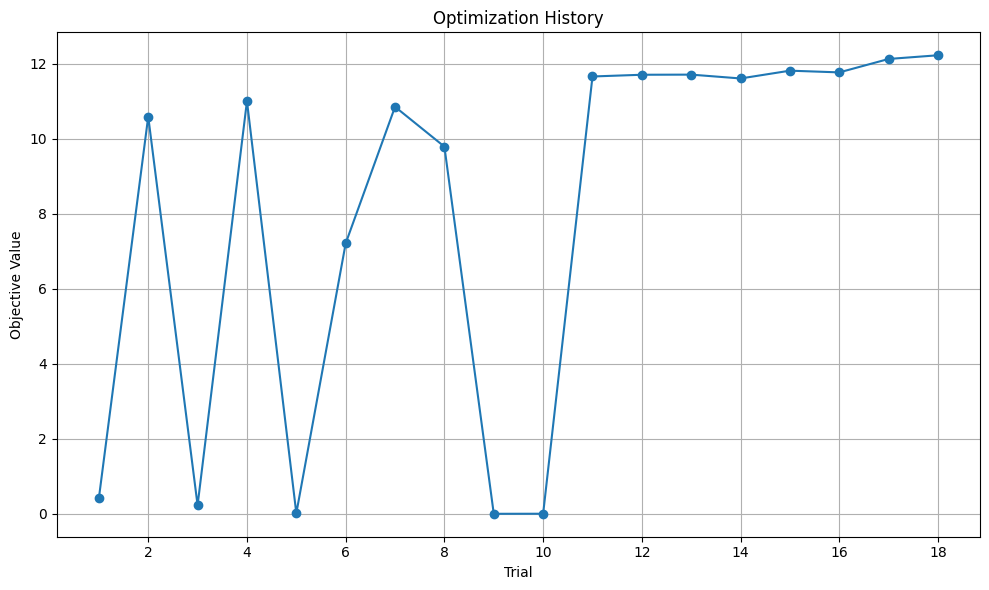

[✓] Saved: Optimization History


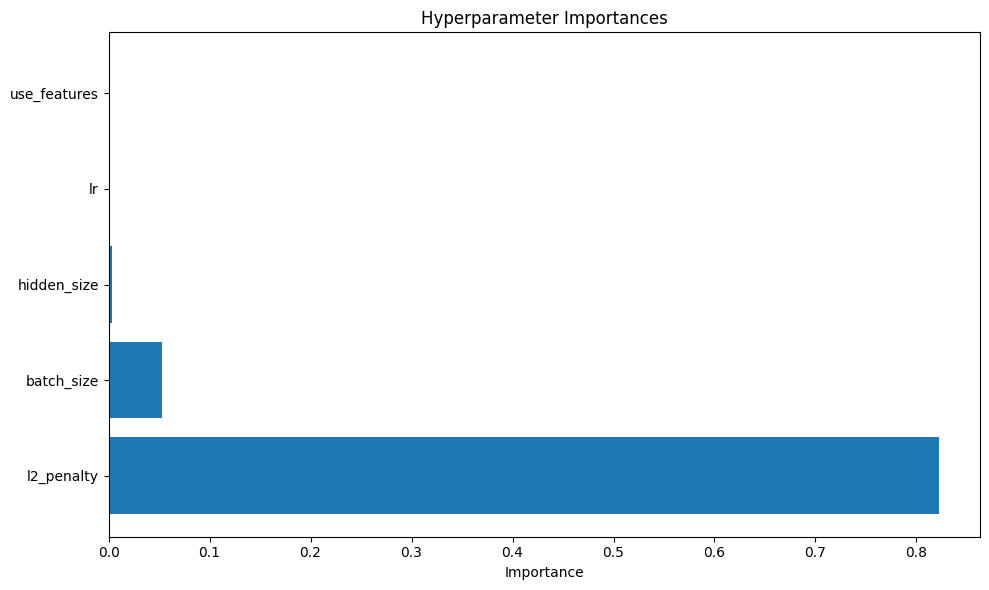

[✓] Saved: Parameter Importances


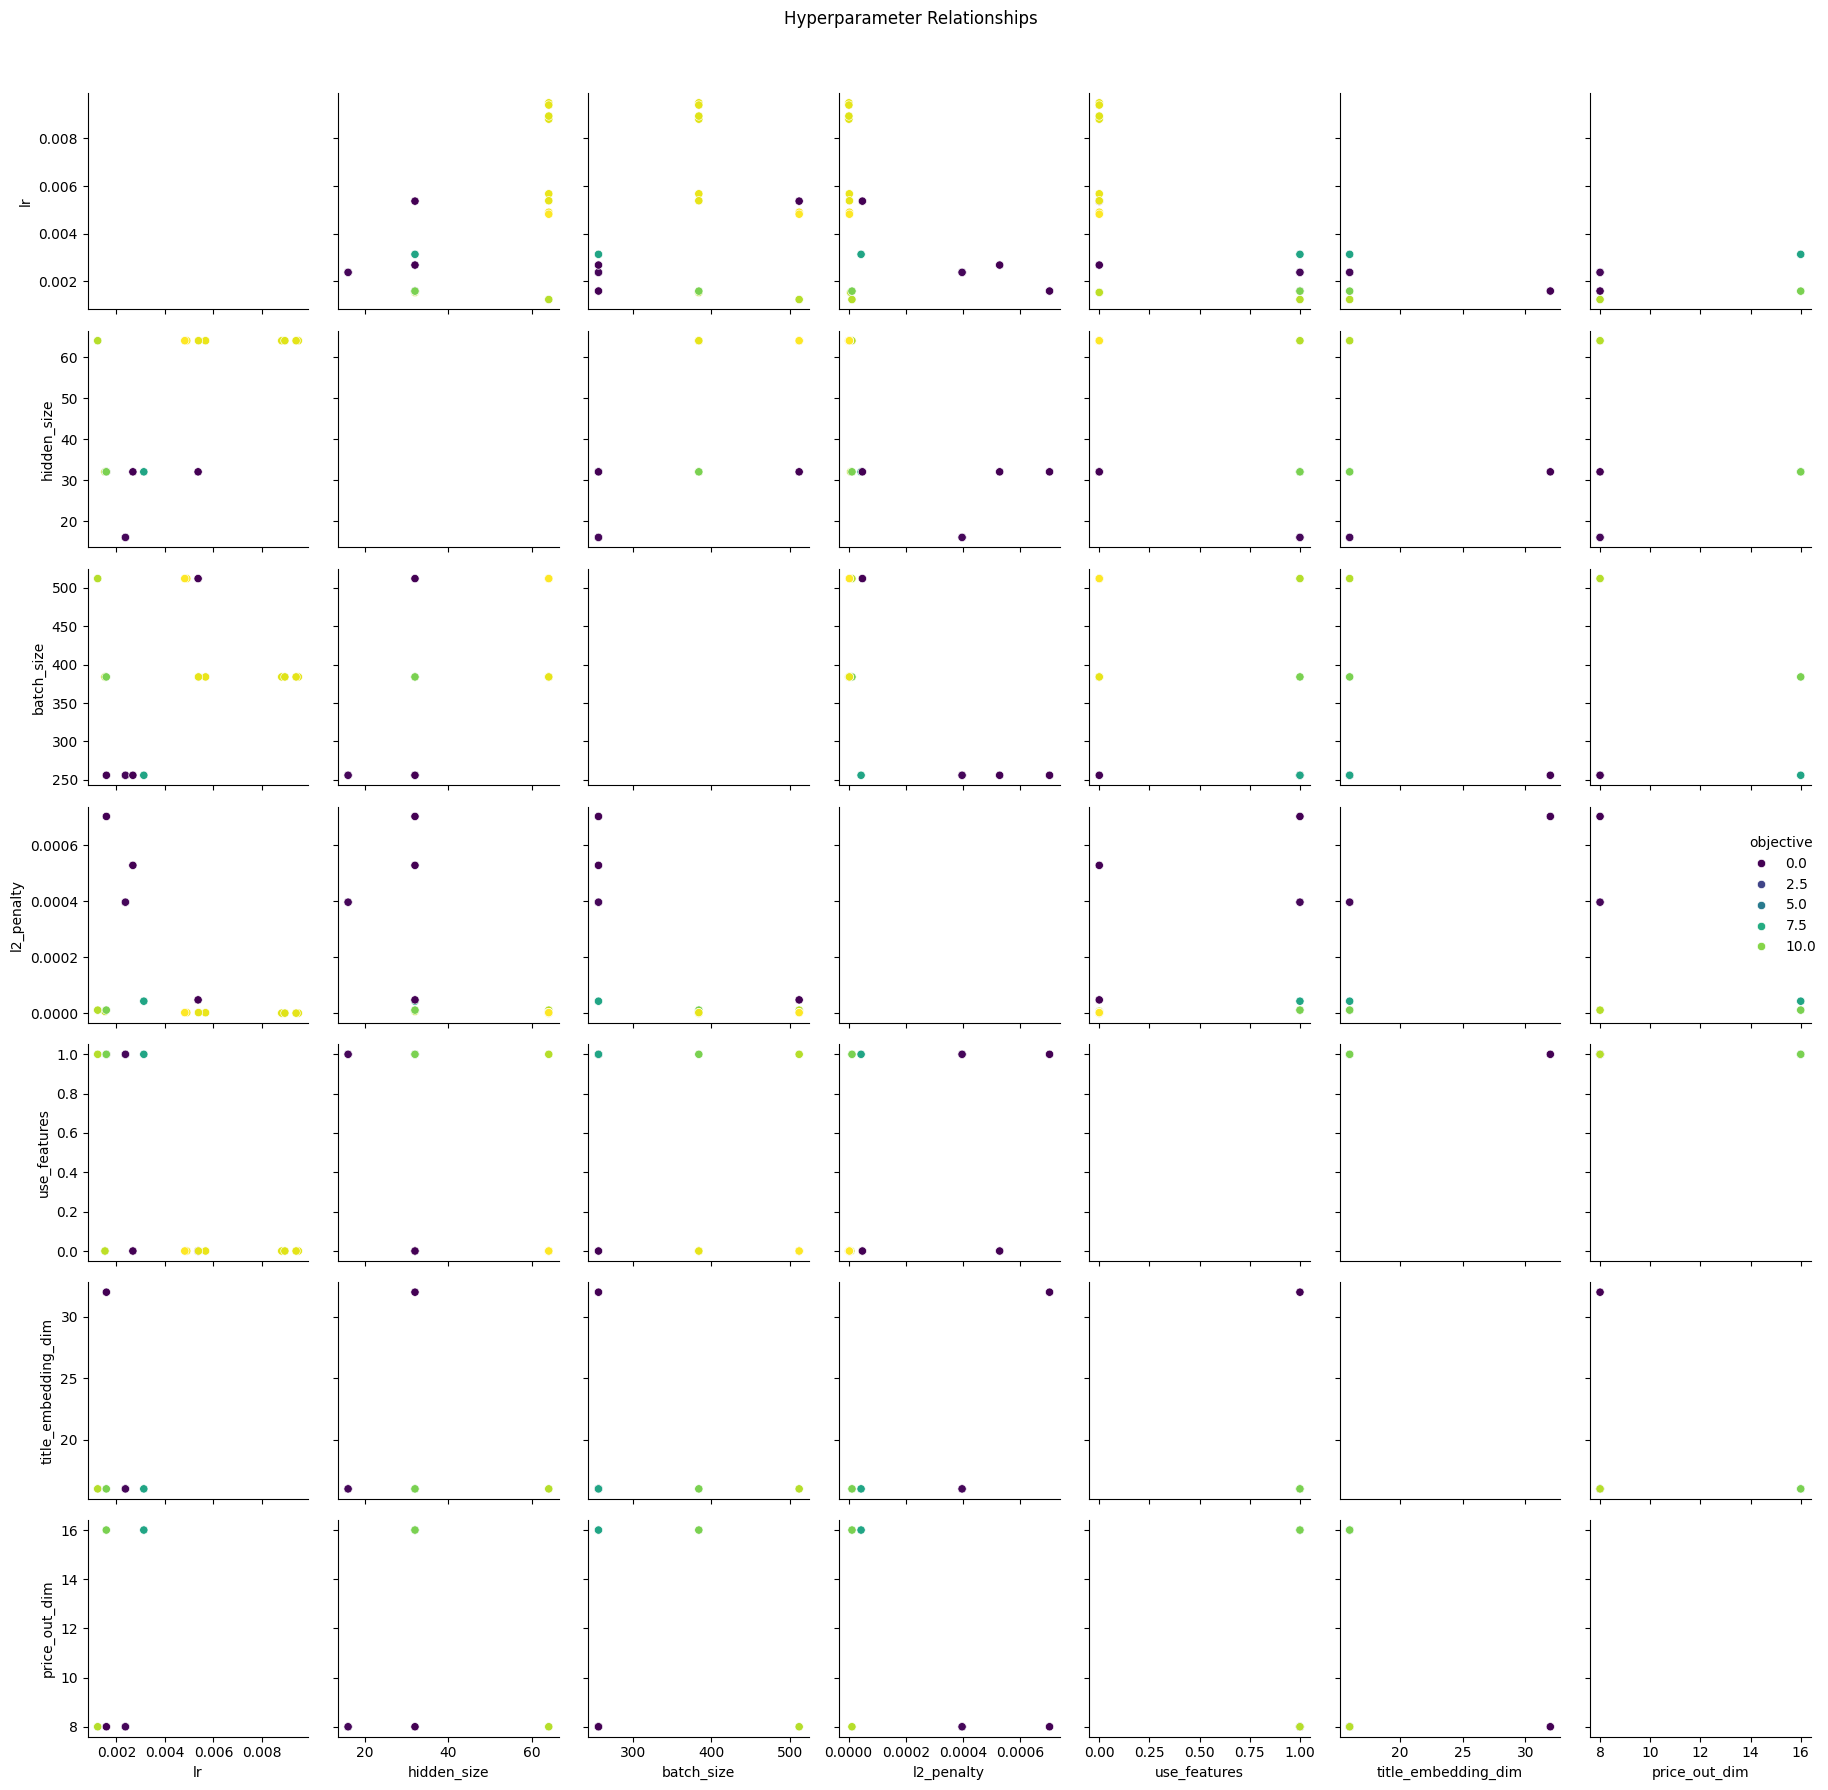

[✓] Saved: Hyperparameter Relationships


In [ ]:
visualize_optuna_results(study, CHECKPOINT_DIR)

In [ ]:
import kaleido
print("Kaleido is available")

Kaleido is available


### Train dengan best param

In [ ]:
print("Training final model with best hyperparameters...")



hp_tuning_args1 = ObjectViewNonRecursive(
    {
    'batch_size': 512,
    'hidden_size': 32,
    'epochs':7,
    'l2_penalty': 0.00001,
    'weight_decay': 0.1,
    'step': 30,
    'lr': 0.001,
    'n_items': label_encoder.classes_.shape[0],
    'num_embeddings': num_embeddings,
    'title_embedding_dim': 16,
    'price_out_dim': 8,
    'n_trials':20,
    'patience':3
}
)



# Train final model with best hyperparameters
best_model, test_results = train_model_with_best_params(
    model_class=SRGNN,
    best_params=best_trial.params,
    args=hp_tuning_args1,
    train_data=train_dataset,
    val_data=val_dataset,
    test_data=test_dataset,
    device=device,
    start_from_beginning=False

)

Training final model with best hyperparameters...
Resuming training from epoch 7
Loaded previous best model with accuracy 12.24%
Training already completed. Returning last best model.


  0%|          | 0/115 [00:00<?, ?it/s]

2025/05/15 16:04:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/15 16:05:01 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'pyg-lib'}
2025/05/15 16:05:01 WARNING mlflow.utils.requirements_utils: Found pyg-lib version (0.4.0+pt25cu124) contains a local version label (+pt25cu124). MLflow logged a pip requirement for this package as 'pyg-lib==0.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, pl

In [ ]:
print("Final test results:")
print(f"Overall Accuracy: {test_results.overall.accuracy*100:.4f}%")
print(f"Hit@k: {test_results.overall.hit_rate*100:.4f}%")
print(f"MRR@k: {test_results.overall.mrr*100:.4f}%")

print("Results by session length:")
for session_type in ["short", "medium", "long"]:
    print(f"  {session_type.capitalize()} sessions:")
    print(f"    Accuracy: {getattr(getattr(test_results, session_type), 'accuracy')*100:.4f}%")
    print(f"    Hit@k: {getattr(getattr(test_results, session_type), 'hit_rate')*100:.4f}%")
    print(f"    MRR@k: {getattr(getattr(test_results, session_type), 'mrr')*100:.4f}%")

# Save final model
torch.save(best_model.state_dict(), f"{CHECKPOINT_DIR}/srgnn_best_model.pt")
print(f"Best model saved to {CHECKPOINT_DIR}/srgnn_best_model.pt")

Final test results:
Overall Accuracy: 12.3896%
Hit@k: 28.0707%
MRR@k: 16.3588%
Results by session length:
  Short sessions:
    Accuracy: 12.6374%
    Hit@k: 28.5823%
    MRR@k: 16.8798%
  Medium sessions:
    Accuracy: 12.5339%
    Hit@k: 28.1054%
    MRR@k: 16.3862%
  Long sessions:
    Accuracy: 10.1500%
    Hit@k: 25.3089%
    MRR@k: 13.6026%
Best model saved to /content/drive/My Drive/TA/Implementasi/SRGNN/Checkpoints/srgnn_best_model.pt


In [ ]:


model.load_state_dict(torch.load('/content/drive/My Drive/Tugas Akhir/SRGNN/Checkpoints/srgnn_best_model.pt'))

In [ ]:
k = 20
test_loader = pyg_data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
results = test(test_loader, model, is_validation=False, k=20)